# Using the Food101 dataset for multiclass classification with Tensorflow Hub prebuilt models

In [7]:
import zipfile

# Download zip file of 10_food_classes images
# See how this data was created - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-05-12 11:13:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  76.5MB/s    in 8.2s    

2024-05-12 11:13:51 (60.3 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [8]:
import os

# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [9]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [10]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [11]:
import tensorflow as tf


In [12]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_ds = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
val_ds = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 7500 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [13]:
num_classes = len(class_names)
import tensorflow_hub as hub
from tensorflow.keras import layers
IMAGE_SHAPE = (224, 224)

In [19]:
# Resnet 50 V2 feature vector
#resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

resnet_url = "https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1"

# Original: EfficientNetB0 feature vector (version 1)
#efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [17]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [14]:


# Create model
#resnet_model = create_model(resnet_url, num_classes=num_classes)
resnet_model = tf.keras.Sequential([
    hub.KerasLayer("https://kaggle.com/models/google/resnet-v2/TensorFlow2/50-feature-vector/1",
                   trainable=False,
                   name='feature_extraction_layer',
                   input_shape=IMAGE_SHAPE+(3,)), # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [26]:
# Fit the model
resnet_history = resnet_model.fit(train_ds,
                                  epochs=10,
                                  steps_per_epoch=len(train_ds),
                                  validation_data=val_ds,
                                  validation_steps=len(val_ds))

Epoch 1/10
235/235 [==============================] - 1894s 8s/step - loss: 0.9050 - accuracy: 0.7048 - val_loss: 0.5289 - val_accuracy: 0.8212
Epoch 2/10
235/235 [==============================] - 1839s 8s/step - loss: 0.5345 - accuracy: 0.8252 - val_loss: 0.4655 - val_accuracy: 0.8468
Epoch 3/10
235/235 [==============================] - 1819s 8s/step - loss: 0.4355 - accuracy: 0.8545 - val_loss: 0.4635 - val_accuracy: 0.8456
Epoch 4/10
235/235 [==============================] - 1861s 8s/step - loss: 0.3666 - accuracy: 0.8797 - val_loss: 0.4572 - val_accuracy: 0.8456
Epoch 5/10
235/235 [==============================] - 1806s 8s/step - loss: 0.3197 - accuracy: 0.8983 - val_loss: 0.4600 - val_accuracy: 0.8448
Epoch 6/10
235/235 [==============================] - 1789s 8s/step - loss: 0.2820 - accuracy: 0.9153 - val_loss: 0.4602 - val_accuracy: 0.8472
Epoch 7/10
235/235 [==============================] - 1804s 8s/step - loss: 0.2524 - accuracy: 0.9259 - val_loss: 0.4691 - val_accuracy:

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [20]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_ds, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_ds),
                                              validation_data=val_ds,
                                              validation_steps=len(val_ds))

Epoch 1/5
235/235 [==============================] - 749s 3s/step - loss: 0.8179 - accuracy: 0.7692 - val_loss: 0.4034 - val_accuracy: 0.8908
Epoch 2/5
235/235 [==============================] - 690s 3s/step - loss: 0.4460 - accuracy: 0.8683 - val_loss: 0.3306 - val_accuracy: 0.9072
Epoch 3/5
235/235 [==============================] - 700s 3s/step - loss: 0.3745 - accuracy: 0.8889 - val_loss: 0.3056 - val_accuracy: 0.9080
Epoch 4/5
235/235 [==============================] - 738s 3s/step - loss: 0.3298 - accuracy: 0.9023 - val_loss: 0.2870 - val_accuracy: 0.9116
Epoch 5/5
235/235 [==============================] - 772s 3s/step - loss: 0.2975 - accuracy: 0.9108 - val_loss: 0.2791 - val_accuracy: 0.9156


In [21]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

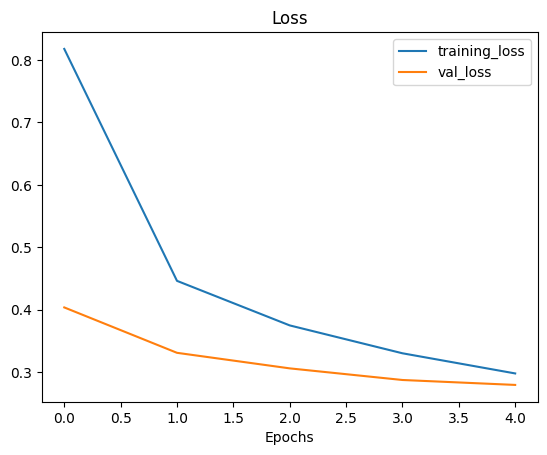

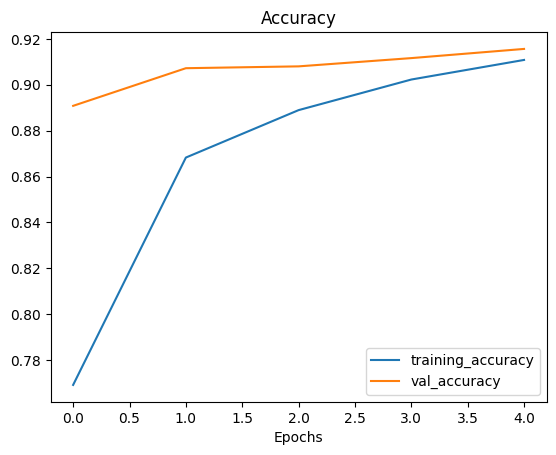

In [22]:
plot_loss_curves(efficientnet_history)

In [23]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
